In [1]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from IPython.display import Image, display

import matplotlib as mpl

import networkx as nx

from operator import itemgetter

from matplotlib.backends.backend_pdf import PdfPages

import pydot

In [2]:
#df=pd.read_excel("C:/Users/edoardo.marchi/Dropbox/microbiome/SoilHealth-Fungi_mod.xlsx", skiprows=3) 
df=pd.read_excel("C:/Users/edo13/Dropbox/microbiome/SoilHealth-Fungi_mod.xlsx", skiprows=3) 
df = df.drop(columns = ["LOC", "DEPTH", "REP"])
df=df.fillna(0.)
df.replace(" ", 0, inplace=True)

In [3]:
cols=list(df.columns)

phyla=cols[11:21]
genera = cols[22:319]

In [4]:
df_phyla = pd.concat( [ df[["SITE", "TREAT", "Season"]], df[phyla] ], axis = 1)

In [5]:
norm=df_phyla[phyla].sum(axis=1, numeric_only=True)

In [6]:
# remove zero rows
df_phyla=df_phyla.iloc[norm[norm.values>0.].index]


In [7]:
norm=norm[norm.values>0.]
for col in phyla:
    df_phyla[col]=df_phyla[col]/norm  

In [39]:
def create_network(df_phyla, phyla, parameter, par_value, threshold, node_size = 3e3):

    corr_matrix = df_phyla[ df_phyla[parameter] == par_value ][phyla].corr(method = 'spearman')
    corr_matrix = corr_matrix.fillna(0.)

    phyla_filtered = []

    for col in phyla:
        if (abs(corr_matrix[col]) > threshold).sum() <= 1:
            corr_matrix = corr_matrix.drop(index = col, columns = col)
        else: 
            phyla_filtered.append(col)     

    # Create a networkx graph
    G = nx.Graph()

    node_sizes = node_size*df_phyla[phyla_filtered].mean()  # Example sizes

    # Add nodes (variables)
    for col in corr_matrix.columns:
        G.add_node(col)

    # Add edges (correlations) - only add edges with correlation greater than a threshold (e.g., 0.1)
    threshold = 0.3
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            weight = corr_matrix.iloc[i, j]
            if abs(weight) > threshold:

                G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j], weight=weight)

    # Keep only the largest connected component
    if nx.is_connected(G):
        largest_component = G  # Already connected, nothing to change
    else:
        largest_cc_nodes = max(nx.connected_components(G), key=len)  # Get largest connected component
        G = G.subgraph(largest_cc_nodes).copy()  # Create subgraph with only these nodes

    filtered_node_sizes = [node_sizes[node] for node in G.nodes if node in node_sizes]  # Keep sizes only for remaining nodes

    # Define edge colors based on weight
    edge_colors = ['red' if G[u][v]['weight'] > 0 else 'navy' for u, v in G.edges()]            

    # Get the edge weights
    edge_weights = nx.get_edge_attributes(G, 'weight')            

    # Normalize the weights to get proportional thickness (you can scale as needed)
    min_weight = abs(min(edge_weights.values()))
    max_weight = 2*abs(max(edge_weights.values()))
    
    edge_widths = [5 * (weight - min_weight) / (max_weight - min_weight) for weight in edge_weights.values()]
    
    return G, filtered_node_sizes, edge_widths, edge_colors, edge_weights 

In [43]:
def network_statistics(G):
    """
    Computes basic statistics of a given network G.
    
    Parameters:
    G (networkx.Graph): The input graph.
    
    Returns:
    dict: A dictionary containing the total number of nodes, total number of edges,
          average degree, and average clustering coefficient.
    """
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    avg_degree = sum(dict(G.degree()).values()) / num_nodes if num_nodes > 0 else 0
    avg_clustering = nx.average_clustering(G)
    avg_path_len = nx.average_shortest_path_length(G)
    
    return {
        "Total Nodes": num_nodes,
        "Total Edges": num_edges,
        "Average Degree": avg_degree,
        "Average Clustering Coefficient": avg_clustering,
        "Average Path Length": avg_path_len
    }

# GENERA 

In [10]:
df_genera = pd.concat( [ df[["SITE", "TREAT", "Season"]], df[genera] ], axis = 1)

In [11]:
norm=df_genera.iloc[:, 3:].sum(axis=1, numeric_only=True)

In [12]:
# remove zero rows
df_genera = df_genera.iloc[norm[norm.values>0.].index]
df_genera.reset_index(inplace = True, drop = True)

In [13]:
norm = norm[ norm.values > 0.]

In [14]:
norm.reset_index(drop = True, inplace = True)

In [15]:
for i in range(len(df_genera)):
    df_genera.iloc[i, 3:]=df_genera.iloc[i, 3:]/norm[i]

NETWORK STATISTICS for SITE N
{'Total Nodes': 124, 'Total Edges': 355, 'Average Degree': 5.725806451612903, 'Average Clustering Coefficient': 0.6039172455206612, 'Average Path Length': 4.132310516653553}
NETWORK STATISTICS for SITE S
{'Total Nodes': 107, 'Total Edges': 323, 'Average Degree': 6.037383177570093, 'Average Clustering Coefficient': 0.5507586909456067, 'Average Path Length': 3.987832833715394}


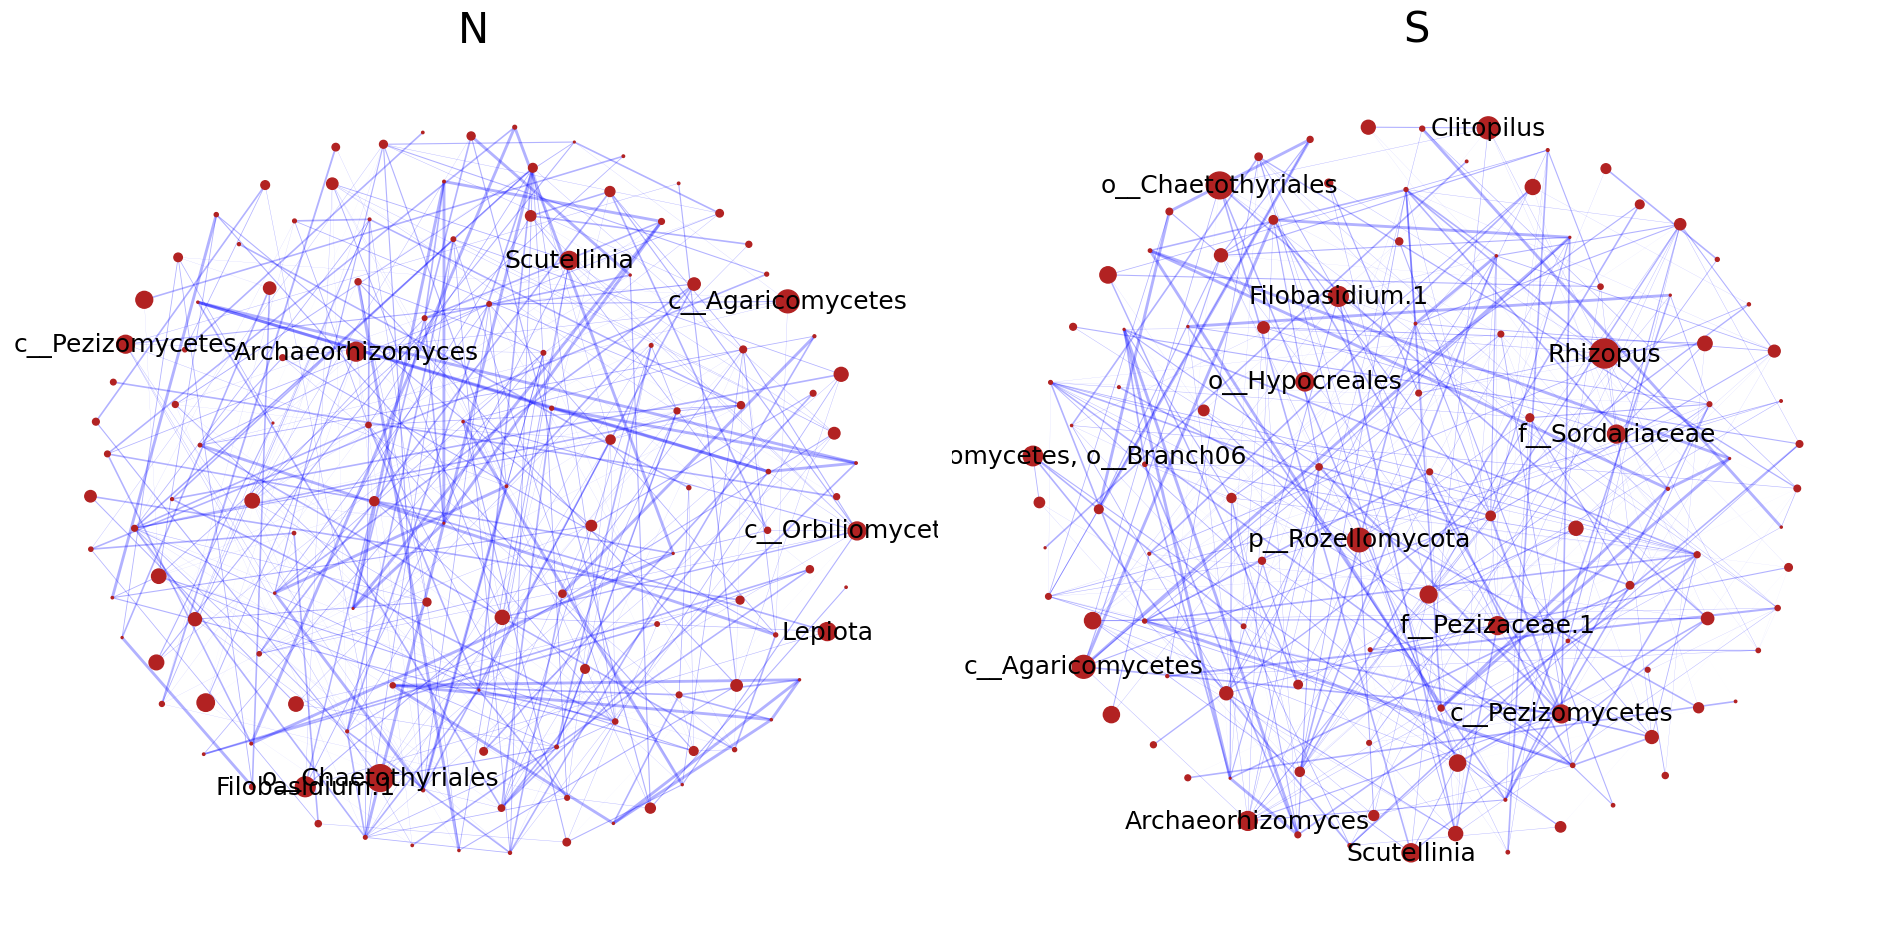

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (1.9*10, 1.9*5), layout = 'tight')

for  i, site in enumerate(["N", "S"]):

    G, node_sizes, edge_widths, edge_colors, edge_weights = create_network(df_genera,
                                                            genera,
                                                            parameter = "SITE", 
                                                            par_value = site, 
                                                            threshold = 0.5,
                                                            node_size = 4e4)
    
    # Plot the graph
    #pos = nx.circular_layout(G)  # Use circular layout for node positioning
    #pos = nx.spring_layout(G)  # Positioning of nodes
    pos = nx.arf_layout(G)
    edge_weights = np.array(list(edge_weights.values()))
    
    for j in range(len(edge_widths)):
        if edge_weights[j] > 0.3:
            edge_widths[j] = edge_widths[j]
        else:
            edge_widths[j] = 0

    # Draw the graph with edge widths proportional to the weights
    nx.draw_networkx_nodes(G, pos, ax = ax[i], node_size=node_sizes, node_color='firebrick')
    nx.draw_networkx_edges(G, pos, ax = ax[i], width=edge_widths, edge_color = 'blue', alpha=0.3)
    #y_off = 0.1
    #nx.draw_networkx_labels(G, pos = {k:([v[0], v[1] + y_off]) for k,v in pos.items()}, ax = ax[i], font_size = 12)
    nx.draw_networkx_labels(G, pos, labels = {n: n for n in G if df_genera[n].mean() > 0.004}, ax = ax[i], font_size = 18)

    ax[i].set_axis_off()  
    ax[i].set_title(site, fontsize = 30)

    print("NETWORK STATISTICS for SITE " + site)
    print(network_statistics(G))

#plt.savefig("pictures_paper/network_genera_site.pdf", bbox_inches = 'tight')

NETWORK STATISTICS for Season SPR
{'Total Nodes': 98, 'Total Edges': 259, 'Average Degree': 5.285714285714286, 'Average Clustering Coefficient': 0.6235236985236985, 'Average Path Length': 4.127077635177782}
NETWORK STATISTICS for Season AUT
{'Total Nodes': 108, 'Total Edges': 304, 'Average Degree': 5.62962962962963, 'Average Clustering Coefficient': 0.510531598031598, 'Average Path Length': 4.257182416060921}


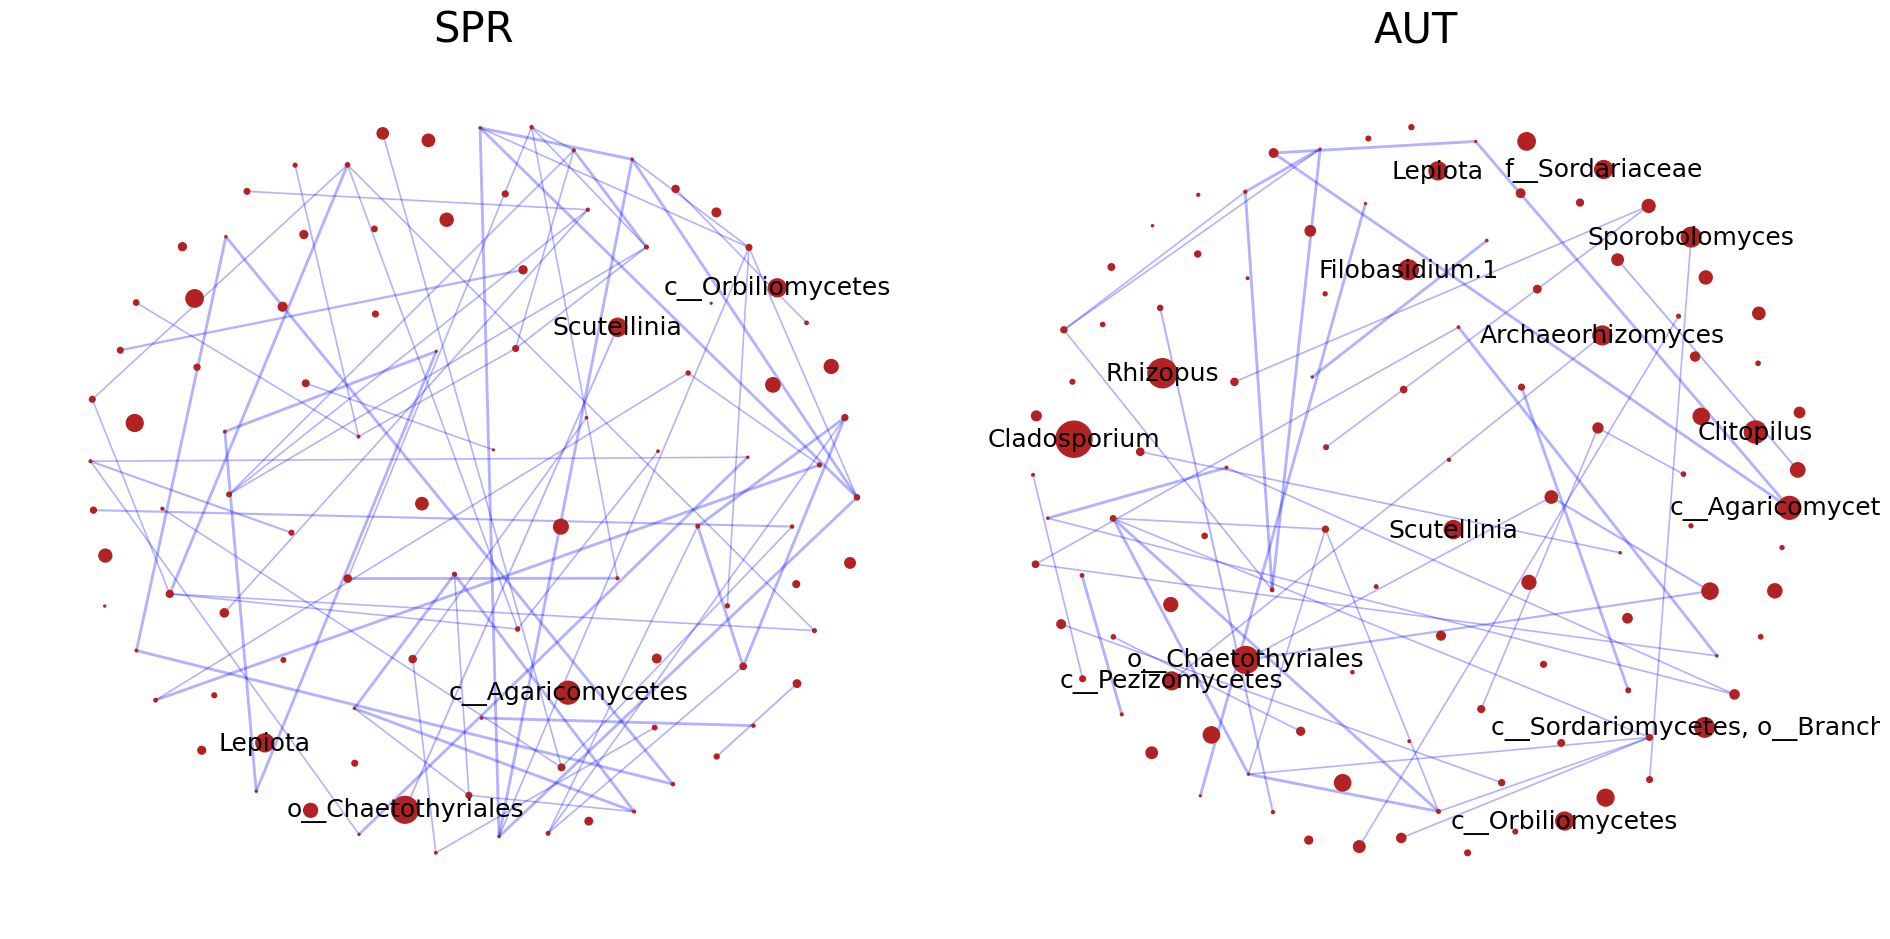

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (1.9*10, 1.9*5), layout = 'tight')

seed = 42

for  i, season in enumerate(["SPR", "AUT"]):

    G, node_sizes, edge_widths, edge_colors, edge_weights = create_network(df_genera,
                                                            genera,
                                                            parameter = "Season", 
                                                            par_value = season, 
                                                            threshold = 0.5,
                                                            node_size = 4e4)

    # Plot the graph
    #pos = nx.circular_layout(G)  # Use circular layout for node positioning
    pos = nx.arf_layout(G)  # Positioning of nodes
    #pos = nx.shell_layout(G)
    
    edge_weights = np.array(list(edge_weights.values()))
    for j in range(len(edge_widths)):
        if edge_weights[j] > 0.7:
            edge_widths[j] = edge_widths[j]
        else:
            edge_widths[j] = 0


    # Draw the graph with edge widths proportional to the weights
    nx.draw_networkx_nodes(G, pos, ax = ax[i], node_size=node_sizes, node_color='firebrick')
    nx.draw_networkx_edges(G, pos, ax = ax[i], width=edge_widths, edge_color = 'blue', alpha = 0.3)
    #y_off = 0.1
    #nx.draw_networkx_labels(G, pos = {k:([v[0], v[1] + y_off]) for k,v in pos.items()}, ax = ax[i], font_size = 12)
    nx.draw_networkx_labels(G, pos, labels = {n: n for n in G if df_genera[n].mean() > 0.004}, ax = ax[i], font_size = 18)

    ax[i].set_axis_off()  
    ax[i].set_title(season, fontsize = 30)

    print("NETWORK STATISTICS for Season " + season)
    print(network_statistics(G))

#plt.savefig("pictures_paper/network_genera_season.pdf", bbox_inches = 'tight')

In [29]:
graph.write_png("output.png", prog = "twopi")

NETWORK STATISTICS for TREAT CO
{'Total Nodes': 131, 'Total Edges': 410, 'Average Degree': 6.259541984732825, 'Average Clustering Coefficient': 0.5130165000394009, 'Average Path Length': 3.834409864944216}
NETWORK STATISTICS for TREAT FC
{'Total Nodes': 107, 'Total Edges': 337, 'Average Degree': 6.299065420560748, 'Average Clustering Coefficient': 0.602935128488498, 'Average Path Length': 4.22324105096103}
NETWORK STATISTICS for TREAT OR
{'Total Nodes': 146, 'Total Edges': 559, 'Average Degree': 7.657534246575342, 'Average Clustering Coefficient': 0.6001477828734074, 'Average Path Length': 3.399149740198394}


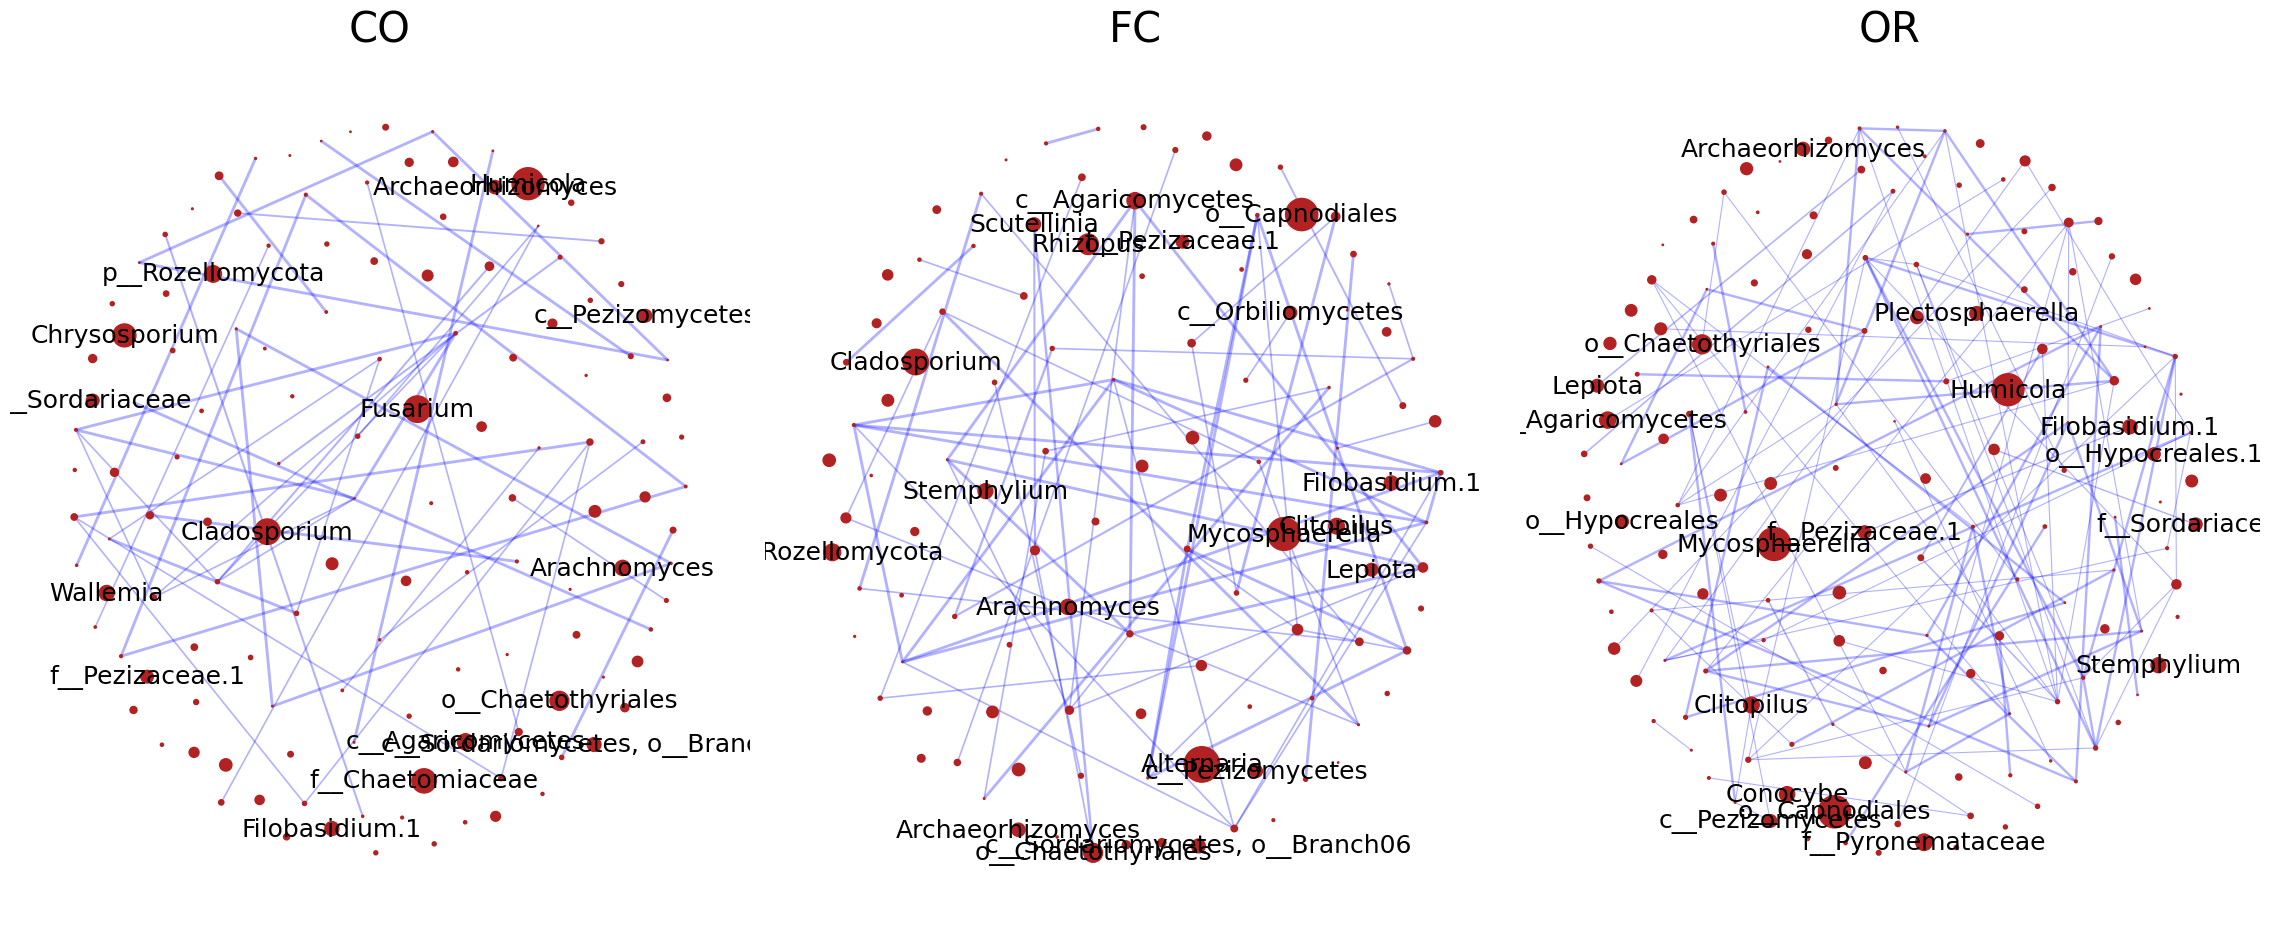

In [47]:
fig, ax = plt.subplots(1, 3, figsize = (1.9*12, 1.9*5), layout = 'tight')

for  i, treat in enumerate(["CO", "FC", "OR"]):

    G, node_sizes, edge_widths, edge_colors, edge_weights = create_network(df_genera,
                                                            genera,
                                                            parameter = "TREAT", 
                                                            par_value = treat, 
                                                            threshold = 0.5,
                                                            node_size = 2e4)

    # Plot the graph
    #pos = nx.circular_layout(G)  # Use circular layout for node positioning
    #pos = nx.spring_layout(G)  # Positioning of nodes
    pos = nx.arf_layout(G)  # Positioning of nodes
    #pos = nx.shell_layout(G)

    edge_weights = np.array(list(edge_weights.values()))
    for j in range(len(edge_widths)):
        if edge_weights[j] > 0.7:
            edge_widths[j] = edge_widths[j]
        else:
            edge_widths[j] = 0    

    # Draw the graph with edge widths proportional to the weights
    nx.draw_networkx_nodes(G, pos, ax = ax[i], node_size=node_sizes, node_color='firebrick')
    nx.draw_networkx_edges(G, pos, ax = ax[i], width=edge_widths, edge_color = 'blue', alpha=0.3)
    #y_off = 0.1
    #nx.draw_networkx_labels(G, pos = {k:([v[0], v[1] + y_off]) for k,v in pos.items()}, ax = ax[i], font_size = 12)
    nx.draw_networkx_labels(G, pos, labels = {n: n for n in G if df_genera[n].mean() > 0.004}, ax = ax[i], font_size = 18)

    ax[i].set_axis_off()  
    ax[i].set_title(treat, fontsize = 30)

    print("NETWORK STATISTICS for TREAT " + treat)
    print(network_statistics(G))    

#plt.savefig("pictures_paper/network_genera_treat.pdf", bbox_inches = 'tight')

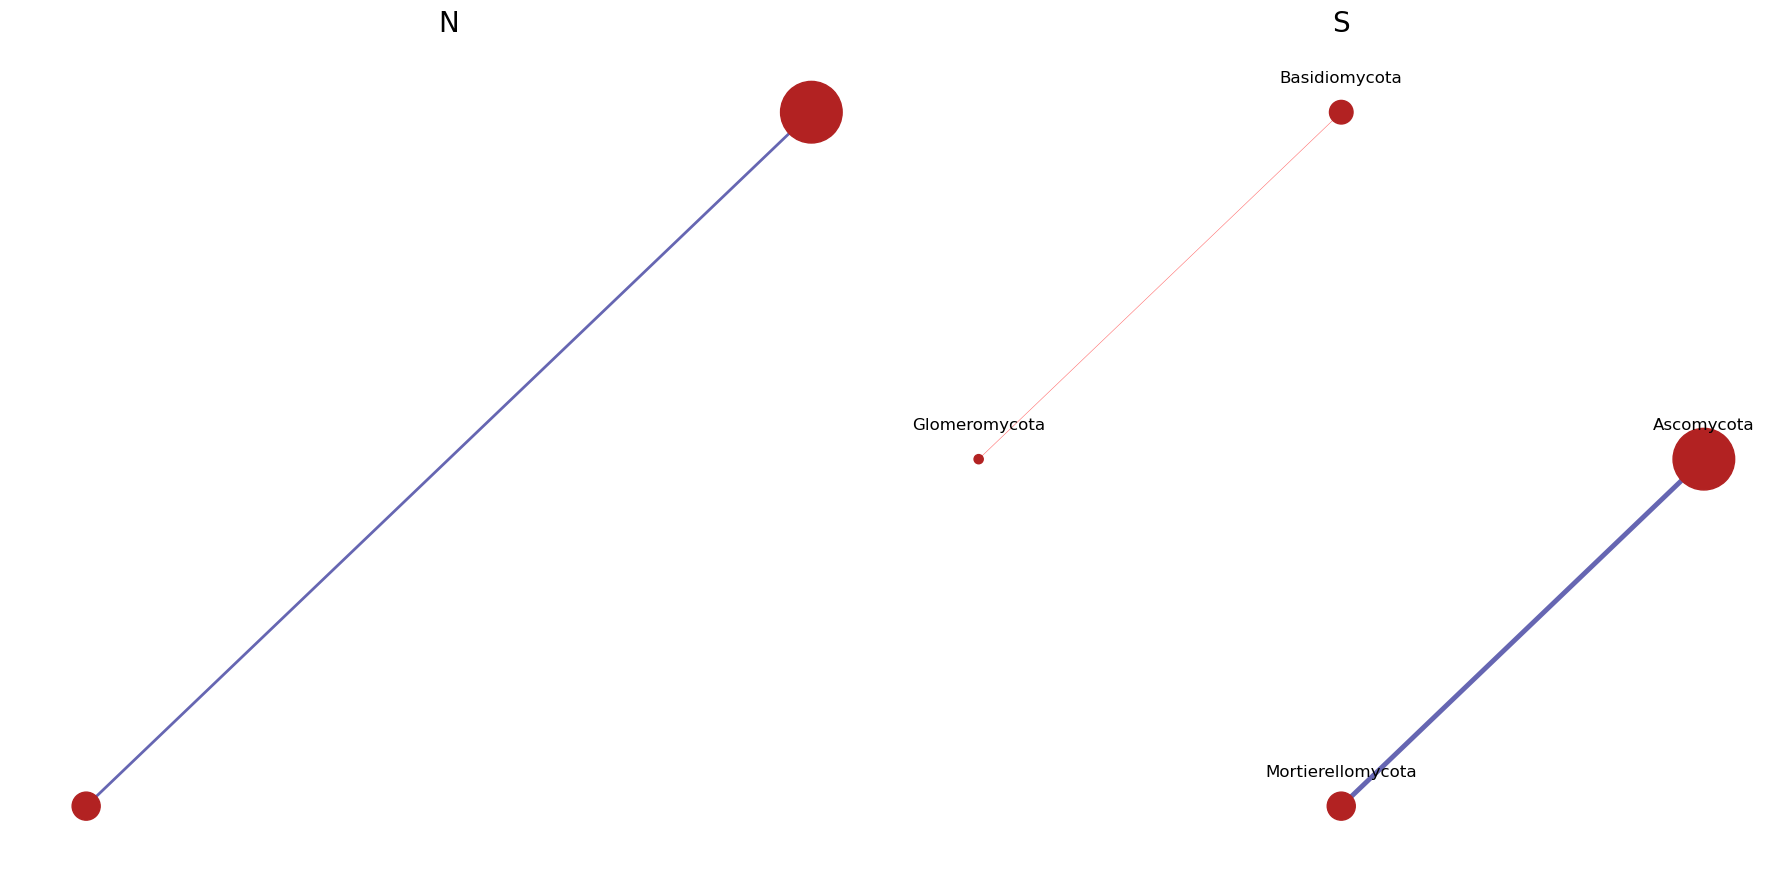

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (1.8*10, 1.8*5), layout = 'tight')

for  i, site in enumerate(["N", "S"]):

    G, node_sizes, edge_widths, edge_colors, edge_weights = create_network(df_phyla, phyla, parameter = "SITE", par_value = site, threshold = 0.5)

    # Plot the graph
    pos = nx.circular_layout(G)  # Use circular layout for node positioning
    #pos = nx.spring_layout(G, scale=0.05)  # Positioning of nodes

    # Draw the graph with edge widths proportional to the weights
    nx.draw_networkx_nodes(G, pos, ax = ax[i], node_size=node_sizes, node_color='firebrick')
    nx.draw_networkx_edges(G, pos, ax = ax[i], width = np.array(edge_widths)/5, edge_color = edge_colors, alpha=0.6)
    #nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    y_off = 0.1
    nx.draw_networkx_labels(G, pos = {k:([v[0], v[1] + y_off]) for k,v in pos.items()}, ax = ax[i], font_size = 12)
    ax[i].set_axis_off()  
    ax[i].set_title(site, fontsize = 20)

#plt.savefig("pictures_paper/network_phyla_site.pdf", bbox_inches = 'tight')

In [47]:
#df_phyla[ df_phyla["TREAT"] == "CO" ][phyla]
corr_matrix = df_phyla[ df_phyla["TREAT"] == "CO" ][phyla].corr(method = 'spearman')

In [48]:
corr_matrix

,Ascomycota,Basidiomycota,Chytridiomycota,Glomeromycota,Kickxellomycota,Mortierellomycota,Mucoromycota,Olpidiomycota,Rozellomycota,uni
Ascomycota,1.000000,-0.439001,-0.029358,-0.125156,-0.072901,-0.552586,-0.156169,-0.189319,-0.337111,0.102640
Basidiomycota,-0.439001,1.000000,-0.040115,0.240290,0.116688,-0.187047,0.065049,0.101803,-0.161291,0.062947
Chytridiomycota,-0.029358,-0.040115,1.000000,-0.073468,-0.053124,0.007482,0.090013,-0.092973,0.181402,0.394236
Glomeromycota,-0.125156,0.240290,-0.073468,1.000000,0.125893,0.043938,0.113323,0.198051,-0.162001,0.013050
Kickxellomycota,-0.072901,0.116688,-0.053124,0.125893,1.000000,0.033165,-0.045118,-0.018230,-0.040014,0.122078
Mortierellomycota,-0.552586,-0.187047,0.007482,0.043938,0.033165,1.000000,0.035768,-0.032600,0.480580,-0.201058
Mucoromycota,-0.156169,0.065049,0.090013,0.113323,-0.045118,0.035768,1.000000,-0.078961,-0.173311,0.143027
Olpidiomycota,-0.189319,0.101803,-0.092973,0.198051,-0.018230,-0.032600,-0.078961,1.000000,-0.070029,-0.180269
Rozellomycota,-0.337111,-0.161291,0.181402,-0.162001,-0.040014,0.480580,-0.173311,-0.070029,1.000000,0.019071
uni,0.102640,0.062947,0.394236,0.013050,0.122078,-0.201058,0.143027,-0.180269,0.019071,1.000000


In [35]:
df_phyla_co.corr(method = 'spearman')

TypeError: Series.corr() missing 1 required positional argument: 'other'